# Short description: 


<li><b>The CIFAR10 dataset</b>: </li>
    - 50,000 images for training; 10,000 images for testing<br>
    - RGB images of shape 32x32<br>
<br>
<li><b>The project</b>:</li>
    - The aim is to train a neural network that takes as input the mean of two random CIFAR10 images, and that outputs the two original images that were used to create the input.<br>
<br>  
<li><b>The approach</b>:</li>
    - To achieve this, I developped two architectures. The first one is a classical convolutional autoencoder, while the second one is a deep convolutional Wasserstein-GAN where I added a discriminator to encourage the generator to produce more realistic images. 


In [1]:
# Torch tools
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from random import randint
from time import time

# Download and visualize the dataset

In [2]:
# Download the dataset
train_dataset = datasets.CIFAR10(
    root = './input/data',
    train = True,
    download = False,   # True if you need to download it 
    transform = ToTensor()
)
test_dataset = datasets.CIFAR10(
    root = './input/data',
    train = False,
    download = False,    # True if you need to download it
    transform = ToTensor()
)

In [3]:
# A dictionary to map each label to the family it represents
labels_map = {  
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

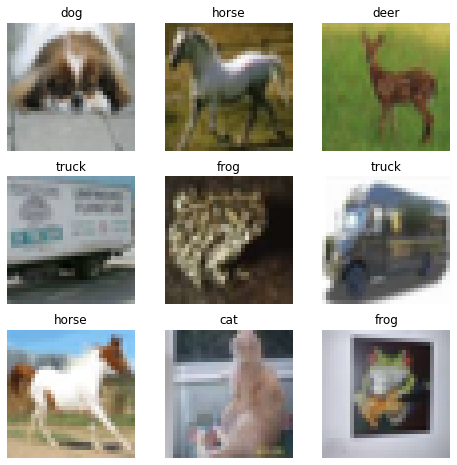

In [4]:
# Visualisation of our data
figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1, )).item()  
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(img.numpy(), [1, 2, 0]))
plt.show()

# Creation of our new dataset: 

>To train our model, we first need to create a new dataset that contains tuples (ground_truth1, ground_truth2, input) where: 
- ground_truth1 is a random image from our dataset;
- ground_truth2 is another random image from our dataset;
- input is the mean of ground_truth1 and ground_truth2.
<br>

> We can arbitrarily choose the length of the new dataset that will be used for the training. Here, I chose a length of 32,000 for the training dataset and a length of 6,400 for the validation dataset, I found that these values were sufficient to obtain an effective training in a reasonable amount of time. 



In [5]:
# Training dataset: 
length_train = 32000  # the length of the training dataset

tensor_data_train = []
for i in range(length_train):   
    groundtruth1, _ = train_dataset[randint(0, len(train_dataset) - 1)]   
    groundtruth2, _ = train_dataset[randint(0, len(train_dataset) - 1)]  
    x_mean = (groundtruth1 + groundtruth2) / 2
    tensor_data_train.append((groundtruth1, groundtruth2, x_mean))

# Validation dataset: 
length_test = 6400  # the length of the validation data set 

tensor_data_val = []
for i in range(length_test):   
    groundtruth1, _ = test_dataset[randint(0, len(test_dataset) - 1)]   
    groundtruth2, _ = test_dataset[randint(0, len(test_dataset) - 1)]  
    x_mean = (groundtruth1 + groundtruth2) / 2
    tensor_data_val.append((groundtruth1, groundtruth2 ,x_mean))

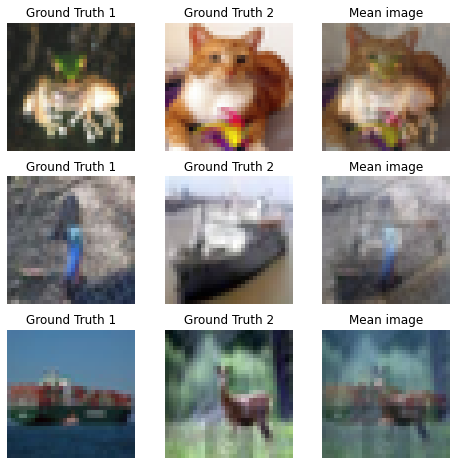

In [6]:
# Visualisation of our new dataset:
figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, 4):
    x1, x2, x_mean = tensor_data_train[randint(0, len(tensor_data_train) - 1)]
    
    figure.add_subplot(rows, cols, 3 * (i - 1) + 1)
    plt.title("Ground Truth 1")
    plt.axis("off")
    plt.imshow(np.transpose(x1.numpy(), [1, 2, 0]))

    figure.add_subplot(rows, cols, 3 * (i - 1) + 2)
    plt.title("Ground Truth 2")
    plt.axis("off")
    plt.imshow(np.transpose(x2.numpy(), [1, 2, 0]))

    figure.add_subplot(rows, cols, 3 * (i - 1) + 3)
    plt.title("Mean image")
    plt.axis("off")
    plt.imshow(np.transpose(x_mean.numpy(), [1, 2, 0]))
plt.show()


> One can see that it is not straightforward to derive the two ground-truth images from the input. A lot of information is lost in the average transformation and, even for a human, it is often challenging to say with certainty the composition of each input. 

In [7]:
# Create dataloader: 
train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(tensor_data_val, batch_size = 64, shuffle = True)

# Utility functions: 

In [8]:
# Some functions we will use: 
def get_device():
    if torch.cuda.is_available():
        return 'cuda:0'
    return 'cpu'


def weights_init(m):
    """
    Function to customise weights initialization
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)


def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

In [9]:
# EarlyStopping Class
class EarlyStopping:
    """EarlyStopping stops the training if validation loss doesn't improve after a given patience number."""
    def __init__(self, patience = 5, verbose = False, delta = 0, path = 'checkpoint.pt', trace_func = print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [18]:
def visualize_results(net, dataloader, num_samples=5):
    """Function to try our model and visualize the results"""
    groundtruth1, groundtruth2, input = next(iter(dataloader)) 
    groundtruth1, groundtruth2, input  = groundtruth1.to(device), groundtruth2.to(device), input.to(device)
    out1, out2 = net(input)
    out1, out2 = out1.to(device), out2.to(device)

    figure = plt.figure(figsize = (8, 8))
    cols, rows =  5, num_samples
    
    for i in range(1, num_samples + 1):
        j = randint(0, 63)

        figure.add_subplot(rows, cols, 5 * (i - 1) + 1)
        plt.title("Im 1")
        plt.axis("off")
        img1 = np.transpose(groundtruth1[j].cpu().numpy(), [1, 2, 0])
        plt.imshow(img1)

        figure.add_subplot(rows, cols, 5 * (i - 1) + 2)
        plt.title("Im 2")
        plt.axis("off")
        img2 = np.transpose(groundtruth2[j].cpu().numpy(), [1, 2, 0])
        plt.imshow(img2)

        figure.add_subplot(rows, cols, 5 * (i - 1) + 3)
        plt.title("Mean image")
        plt.axis("off")
        img3 = np.transpose(input[j].cpu().numpy(), [1, 2, 0])
        plt.imshow(img3)

        figure.add_subplot(rows, cols, 5 * (i - 1) + 4)
        plt.title("Out1")
        plt.axis("off")
        img4 = np.transpose(out1[j].detach().cpu().numpy(), [1, 2, 0])
        plt.imshow(img4)

        figure.add_subplot(rows,cols, 5 * (i - 1) + 5)
        plt.title("Out2")
        plt.axis("off")
        img5 = np.transpose(out2[j].detach().cpu().numpy(), [1, 2, 0])
        plt.imshow(img5)

# First model: Deep Convolutional AutoEncoder

<li><b> Structure </b>: </li>
    - 1 encoder: takes the input x_mean and outputs z<br>
    - 2 decoders: each decoder takes z as an input and outputs an image<br>
<br>

<b> NB</b>: the main difficulty is that we do not know the order of the outputs (i.e. if the output of a decoder reprents the first ground truth or the second ground truth)
<br>  

In [11]:
# The autoencoder: 
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder 
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        # Decoder 1 
        self.decode1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3),
            nn.ReLU(True)
        )
        # Decoder 2
        self.decode2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3),
            nn.ReLU(True)
        )
    
    def forward(self, input):
        z = self.encode(input)
        out1 = self.decode1(z)
        out2 = self.decode2(z)
        return out1, out2

# The training of the autoencoder:

To train our model, we need to find an efficient loss function. As we do not know the order of the outputs generated by the model, we can't directly compare each output with a ground truth. Therefore, our loss function is composed of 2 terms: 
- The first loss minimizes the difference between the mean of the two ouptus and the input
- The second loss minimizes the difference between $\lvert{GroundTruth_1 - GroundTruth_2}\rvert$ and $\lvert{output_1 - output_2}\rvert$

Finally, we use a weight $\alpha$ to balance the importance of each loss in the final loss such that: 
$$Loss = (1 - \alpha) \times Loss1 + \alpha \times Loss2 $$

By running different tests, I found that $\alpha = 0.1$ (with an adapted learning rate) leads to interesting results. Choosing $\alpha \geq 0.1$ would force the autoencoder to generate images radically different from the ground truth images, resulting in a sub-optimal convergence (example: for any input, the autoencoder returns a red image and a green one).  


In [12]:
# Training function:
def train_AE(net, optimizer, train_loader, val_loader, NUM_EPOCHS, patience = 5):
    """Trains our AutoEncoder"""
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    alpha = 0.1
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience, verbose = True)
    for epoch in range(NUM_EPOCHS):
        running_loss_train = 0.0
        running_loss_val = 0.0

        ##### TRAINING #####
        net.train() # prepare the model for training
        for data in train_loader:
            groundtruth1, groundtruth2, x_in = data  # x_in = mean(groundtruth1, groundtruth2)
            x_in = x_in.to(device)
            groundtruth1 = groundtruth1.to(device)
            groundtruth2 = groundtruth2.to(device)

            optimizer.zero_grad()
            outputs1, outputs2 = net(x_in)  
            outputs1 = outputs1.to(device)
            outputs2 = outputs2.to(device)

            loss_1 =  criterion(outputs2, (x_in * 2) - outputs1) + criterion(outputs1,(x_in * 2) - outputs2)

            diff_Groundtruth = torch.abs(groundtruth1 - groundtruth2)  
            diff_Outputs = torch.abs(outputs1 - outputs2)
            loss_2 = criterion(diff_Outputs, diff_Groundtruth)
            
            loss_train = (1 - alpha) * loss_1 + alpha * loss_2  
            loss_train.backward()
            optimizer.step()
            running_loss_train += loss_train.item()
        
        loss_train = running_loss_train / len(train_loader)
        train_losses.append(loss_train)
    

        ##### VALIDATION #####
        net.eval()
        for data in val_loader:
            groundtruth1, groundtruth2, x_in = data     
            x_in = x_in.to(device)
            groundtruth1 = groundtruth1.to(device)
            groundtruth2 = groundtruth2.to(device)

            outputs1, outputs2 = net(x_in)  
            outputs1 = outputs1.to(device)
            outputs2 = outputs2.to(device)

            # Loss functions: 
            loss_1 =  criterion(outputs1, (x_in * 2) - outputs2) + criterion(outputs2, (x_in * 2) - outputs1)
            

            diff_Groundtruth = torch.abs(groundtruth1 - groundtruth2)  
            diff_Outputs = torch.abs(outputs1 - outputs2)
            loss_2 = criterion(diff_Outputs, diff_Groundtruth)

            loss_val = (1 - alpha) * loss_1 + alpha * loss_2 
            loss_val.backward()
            running_loss_val += loss_val.item()
        
        loss_val = running_loss_val / len(val_loader)
        val_losses.append(loss_val)

        print('Epoch {} of {}, Training loss: {:.4f}, Validation Loss:{:.4f}'.format(
            epoch+1, NUM_EPOCHS, loss_train, loss_val))


        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(loss_val, net)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    return train_losses, val_losses, net

## Choice of learning rate: 

>Considering that $\alpha$ = 0.1 (I carefully chose this value to obtain realistic outputs) we want to see the influence of the learning rate. Therefore, we will try 3 different learning rates and choose the best one for our model.


In [13]:
device = get_device()

# Our criterion
criterion = nn.MSELoss()

# AutoEncoder1 : LR = 0.00001
net1 = AutoEncoder().to(device)
net1.apply(weights_init)
optimizer1 = optim.Adam(net1.parameters(), lr = 0.00001) 

# AutoEncoder2 : LR = 0.00005
net2 = AutoEncoder().to(device)
net2.apply(weights_init)
optimizer2 = optim.Adam(net2.parameters(), lr = 0.00005) 

# AutoEncoder3 : LR = 0.0001
net3 = AutoEncoder().to(device)
net3.apply(weights_init)
optimizer3 = optim.Adam(net3.parameters(), lr = 0.0001) 


In [43]:
print("######################")
print(" Training number 1: lr = 0.00001")
print("######################")
train_losses1, val_losses1, net1 = train_AE(net1, optimizer1, train_loader, test_loader, NUM_EPOCHS = 25, patience = 25)

print("######################")
print(" Training number 2: lr = 0.00005")
print("######################")
train_losses2, val_losses2, net2 = train_AE(net2, optimizer2, train_loader, test_loader, NUM_EPOCHS = 25, patience = 25)

print("######################")
print(" Training number 3: lr = 0.0001")
print("######################")
train_losses3, val_losses3, net3 = train_AE(net3, optimizer3, train_loader, test_loader, NUM_EPOCHS = 25, patience = 25)


######################
 Training number 1: lr = 0.00001
######################
Epoch 1 of 25, Training loss: 1.0672, Validation Loss:0.7176
Validation loss decreased (inf --> 0.717566).  Saving model ...
Epoch 2 of 25, Training loss: 0.5271, Validation Loss:0.3566
Validation loss decreased (0.717566 --> 0.356571).  Saving model ...
Epoch 3 of 25, Training loss: 0.2379, Validation Loss:0.1549
Validation loss decreased (0.356571 --> 0.154895).  Saving model ...
Epoch 4 of 25, Training loss: 0.1230, Validation Loss:0.0970
Validation loss decreased (0.154895 --> 0.096994).  Saving model ...
Epoch 5 of 25, Training loss: 0.0857, Validation Loss:0.0733
Validation loss decreased (0.096994 --> 0.073274).  Saving model ...
Epoch 6 of 25, Training loss: 0.0694, Validation Loss:0.0624
Validation loss decreased (0.073274 --> 0.062447).  Saving model ...
Epoch 7 of 25, Training loss: 0.0606, Validation Loss:0.0555
Validation loss decreased (0.062447 --> 0.055470).  Saving model ...
Epoch 8 of 25, T

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

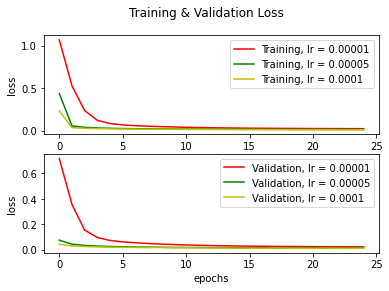

In [44]:
# Visualize the convergence with different learning rates:

fig, axs = plt.subplots(2)

fig.suptitle('Training & Validation Loss')

axs[0].plot(train_losses1,'r',label = "training, LR = 0.00001")
axs[0].plot(train_losses2,'g',label = "training, LR = 0.00005")
axs[0].plot(train_losses3,'y',label = "training, LR = 0.0001")
axs[0].legend()
axs[0].set(xlabel='epochs', ylabel='loss')


axs[1].plot(val_losses1,'r',label = "validation, LR = 0.00001")
axs[1].plot(val_losses2,'g',label = "validation, LR = 0.00005")
axs[1].plot(val_losses3,'y',label = "validation, LR = 0.0001")
axs[1].legend()
axs[1].set(xlabel='epochs', ylabel='loss')



>We can see that all the models seem to converge to the same value. The learning rate only affects the time of convergence. However, we must be careful not to choose a learning rate too important as it may lead to unrealistic outputs. Therefore, we will choose $lr = 0.00005$ (with $\alpha = 0.1$) to visualize the performance of the autoencoder. 


# Performance: 

> As we do not know the order of the outputs generated by the autoencoder, we will only evaluate the performance of our model with a visual analysis of the outputs generated with the test dataset. We will train the model with lr = 0.00005 on 150 epochs with a patience time of 15 epochs.

In [20]:
# Training with lr = 0.00005
net = AutoEncoder().to(device)
net.apply(weights_init)
optimizer = optim.Adam(net.parameters(), lr = 0.00005)
train_losses, val_losses, net = train_AE(net, optimizer, train_loader, test_loader, NUM_EPOCHS = 150, patience = 15)





Epoch 1 of 150, Training loss: 0.5368, Validation Loss:0.0913
Validation loss decreased (inf --> 0.091256).  Saving model...
Epoch 2 of 150, Training loss: 0.0695, Validation Loss:0.0539
Validation loss decreased (0.091256 --> 0.053878).  Saving model...
Epoch 3 of 150, Training loss: 0.0486, Validation Loss:0.0413
Validation loss decreased (0.053878 --> 0.041313).  Saving model...
Epoch 4 of 150, Training loss: 0.0390, Validation Loss:0.0365
Validation loss decreased (0.041313 --> 0.036522).  Saving model...
Epoch 5 of 150, Training loss: 0.0333, Validation Loss:0.0298
Validation loss decreased (0.036522 --> 0.029772).  Saving model...
Epoch 6 of 150, Training loss: 0.0299, Validation Loss:0.0267
Validation loss decreased (0.029772 --> 0.026741).  Saving model...
Epoch 7 of 150, Training loss: 0.0276, Validation Loss:0.0260
Validation loss decreased (0.026741 --> 0.026040).  Saving model...
Epoch 8 of 150, Training loss: 0.0258, Validation Loss:0.0235
Validation loss decreased (0.0260

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


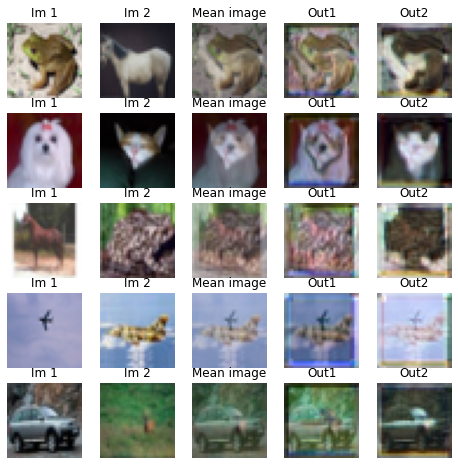

In [22]:
# Quick visualisation on 5 samples from the test dataset: 
visualize_results(net, test_loader, num_samples = 5)

>We can see that after 150 epochs of training, the model is capable of learning important features for each ground truth image such as the color and the shape. Although the two outputs are not identical to the original images, the model manages to produce recognisable images. 

#  Second approach : DC-WGAN 

>To further explore the potenital of this approach, I wanted to add a discriminator that enforces the ouputs to look like real images. Therefore, the generator is similar to the above autoencoder while the discrimintor is a deep convolutional neural network that outputs a score. To enforce the convergence of the GAN, I decided to implement a Wasserstein-GAN. 

In [23]:
# Generator
class Generator(nn.Module):
    """ The generator is our previous autoencoder """
    def __init__(self):
        super(Generator, self).__init__()
        self.encode = nn.Sequential(
            #encoder
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        self.decode1 = nn.Sequential(
            #decoder
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3),
            nn.ReLU(True)
        )
        
        self.decode2 = nn.Sequential(
            #decoder
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3),
            nn.ReLU(True)
        )
        
    
    def forward(self, input):
        z = self.encode(input)
        out1 = self.decode1(z)
        out2 = self.decode2(z)
        return out1, out2

In [24]:
# Discriminator
class Discriminator(nn.Module):
    """  The discriminator is a classical discriminator except that I removed the sigmoid activation of the last layer to 
    obtain a score and not a probability """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, stride = 2, padding = 1, kernel_size = 4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, stride = 2, padding = 1, kernel_size = 4),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, stride = 2, padding = 1, kernel_size = 4),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
        )
        
    def forward(self, input):
        return self.main(input)

In [25]:
# Function to train the discriminator network
def train_discriminator(generator, discriminator, optimizerD, data_real, data_fake):
    
    b_size = data_real.size(0)  
    
    # get the real label vector
    real_label = label_real(b_size)
    
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizerD.zero_grad()
    
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1)
    loss_real = (-1) * torch.mean(output_real)
    
    # compute gradients of real loss 
    loss_real.backward()

    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake).view(-1)
    loss_fake = torch.mean(output_fake)

    # compute gradients of fake loss
    loss_fake.backward()
    
    # update discriminator parameters
    optimizerD.step()

    loss = loss_real + loss_fake

    return loss.item()

In [26]:
# Function to train the generator network
def train_generator(discriminator, optimizerG, data_fake1, data_fake2, x_in, groundtruth1, groundtruth2):
    alpha = 0.1
    b_size = data_fake1.size(0)
    
    # get the real label vector
    real_label = label_real(b_size)
    optimizerG.zero_grad()
    
    # output by doing a forward pass of the fake data through discriminator
    output1 = discriminator(data_fake1).view(-1)
    output2 = discriminator(data_fake2).view(-1)
    
    #loss discriminator
    loss_discriminator = -(torch.mean(output1)  + torch.mean(output2))

    #loss reconstruction
    loss_1 =  criterion(data_fake1, (x_in * 2) - data_fake2) + criterion(data_fake2, (x_in * 2) - data_fake1)
        
    diff_Groundtruth = torch.abs(groundtruth1 - groundtruth2)  
    diff_Outputs = torch.abs(data_fake1 - data_fake2)
    loss_2 = criterion(diff_Outputs, diff_Groundtruth)

    loss_reconstruction =  (1 - alpha) * loss_1  + (alpha) * loss_2

    # Final loss = loss_discriminator + loss_reconstruction
    loss = loss_discriminator + loss_reconstruction
    
    # compute gradients of loss
    loss.backward()
    
    # update generator parameters
    optimizerG.step()
    
    return loss.item() 

In [27]:
# Function to train W-GAN
def train_GAN(generator, generator_optimizer, discriminator, discriminator_optimizer, epochs = 10): 
    criterion = nn.MSELoss()
    losses_g = []
    losses_d = []

    for epoch in range(epochs):
        print('Epoch ' + str(epoch + 1) + ' training...' , end=' ')
        start = time()
        running_loss_d = 0 
        running_loss_g = 0
        for i,  data in enumerate(train_loader):   
            x1, x2, x_mean = data
            real_imgs1 = x1.to(device)
            real_imgs2 = x2.to(device)
            x_mean = x_mean.to(device)
        
            ####################################################
            ############### train Discriminator ################
            ####################################################
      
            # generate a batch of images
            fake_imgs1, fake_imgs2 = generator(x_mean)
        
            # adversarial loss
            running_loss_d += train_discriminator(generator, discriminator, discriminator_optimizer, real_imgs1, fake_imgs1.detach())
            running_loss_d += train_discriminator(generator, discriminator, discriminator_optimizer, real_imgs2, fake_imgs2.detach())

            # clip weights of discriminator
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            ################################################################
            ############# train the generator every 5 iterations ###########
            ################################################################
            if i % 5 == 0:

                # generate a batch of fake images
                critics_fake_imgs1, critics_fake_imgs2  = generator(x_mean)
                # Adversarial loss
                running_loss_g += train_generator(discriminator, generator_optimizer, critics_fake_imgs1, critics_fake_imgs2, x_mean, real_imgs1, real_imgs2)
        
        
        end = time()
        elapsed = end - start

        print('done, took %.1f seconds.' % elapsed)
        epoch_loss_g = running_loss_g / len(train_loader)
        losses_g.append(epoch_loss_g)
        epoch_loss_d = running_loss_d / len(train_loader)
        losses_d.append(epoch_loss_d)
        print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

    return losses_d, losses_g

In [60]:
# Train the GAN with diffirent learning rates: 
device = get_device()
criterion = nn.MSELoss()

# GAN 1 : lr = 0.00001
generator1 = Generator().to(device)
generator1.apply(weights_init)
discriminator1 = Discriminator().to(device)
discriminator1.apply(weights_init)
generator1_optimizer = torch.optim.RMSprop(generator1.parameters(), lr=0.00001)
discriminator1_optimizer = torch.optim.RMSprop(discriminator1.parameters(), lr=0.00001)

# GAN 2 : lr = 0.00005
generator2 = Generator().to(device)
generator2.apply(weights_init)
discriminator2 = Discriminator().to(device)
discriminator2.apply(weights_init)
generator2_optimizer = torch.optim.RMSprop(generator2.parameters(), lr=0.00005)
discriminator2_optimizer = torch.optim.RMSprop(discriminator2.parameters(), lr=0.00005)

# GAN 3 : lr = 0.0001
generator3 = Generator().to(device)
generator3.apply(weights_init)
discriminator3 = Discriminator().to(device)
discriminator3.apply(weights_init)
generator3_optimizer = torch.optim.RMSprop(generator3.parameters(), lr=0.0001)
discriminator3_optimizer = torch.optim.RMSprop(discriminator3.parameters(), lr=0.0001)

In [61]:
print("#################")
print("Training with LR = 0.00001")
print("#################")
losses_d1, losses_g1 = train_GAN(generator1, generator1_optimizer, discriminator1, discriminator1_optimizer, epochs = 15)

print("#################")
print("Training with LR = 0.00005")
print("#################")
losses_d2, losses_g2 = train_GAN(generator2, generator2_optimizer, discriminator2, discriminator2_optimizer, epochs = 15)

print("#################")
print("Training with LR = 0.0001")
print("#################")
losses_d3, losses_g3 = train_GAN(generator3, generator3_optimizer, discriminator3, discriminator3_optimizer, epochs = 15)



#################
Training with LR = 0.00001
#################
Epoch 1 training... done, took 7.4 seconds.
Generator loss: 0.06191128, Discriminator loss: -0.31772046
Epoch 2 training... done, took 6.9 seconds.
Generator loss: 0.14512323, Discriminator loss: -1.14964000
Epoch 3 training... done, took 6.9 seconds.
Generator loss: 0.17259024, Discriminator loss: -1.44904436
Epoch 4 training... done, took 6.9 seconds.
Generator loss: 0.17266010, Discriminator loss: -1.47856274
Epoch 5 training... done, took 6.9 seconds.
Generator loss: 0.16933350, Discriminator loss: -1.47467557
Epoch 6 training... done, took 6.9 seconds.
Generator loss: 0.16560704, Discriminator loss: -1.46355873
Epoch 7 training... done, took 6.9 seconds.
Generator loss: 0.16169886, Discriminator loss: -1.44845003
Epoch 8 training... done, took 6.9 seconds.
Generator loss: 0.15775388, Discriminator loss: -1.43122499
Epoch 9 training... done, took 6.9 seconds.
Generator loss: 0.15491089, Discriminator loss: -1.41561786
E

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

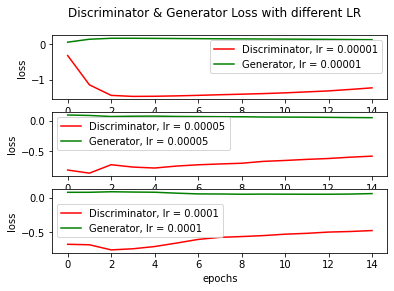

In [62]:
fig, axs = plt.subplots(3)

fig.suptitle('Discriminator & Generator Loss with different LR')

axs[0].plot(losses_d1,'r',label = "Discriminator, lr = 0.00001")
axs[0].plot(losses_g1,'g',label = "Generator, lr = 0.00001")
axs[0].legend()
axs[0].set(xlabel='epochs', ylabel='loss')


axs[1].plot(losses_d2,'r',label = "Discriminator, lr = 0.00005")
axs[1].plot(losses_g2,'g',label = "Generator, lr = 0.00005")
axs[1].legend()
axs[1].set(xlabel='epochs', ylabel='loss')

axs[2].plot(losses_d3,'r',label = "Discriminator, lr = 0.0001")
axs[2].plot(losses_g3,'g',label = "Generator, lr = 0.0001")
axs[2].legend()
axs[2].set(xlabel='epochs', ylabel='loss')

> We can see from the figure presented above that the trade-off between the generator learning and the discriminator learning is more important when a small learning rate is chosen. The convergence is slower but might result in better performance. Therefore, we will consider the model with $LR = 0.00001$ to visualize the performance.

# W-GAN performance: visual evaluation



In [28]:
# GAN: lr = 0.00001
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.00001)
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=0.00001)

**NB**: It is not obvious to find the right time to stop the training with a GAN. After different tests, I found that a training on 30 epochs conducts to the best results. If the training is run on more than 30 epochs, the structure of the outputs degrades. Finally, the images produced by the GAN are less satisfactory than the ones produced by the autoencoder.



In [141]:
# Train the GAN:
losses_d, losses_g = train_GAN(generator, generator_optimizer, discriminator, discriminator_optimizer, epochs = 30)

Epoch 1 training... done, took 7.0 seconds.
Generator loss: 0.14003263, Discriminator loss: -1.21204936
Epoch 2 training... done, took 6.9 seconds.
Generator loss: 0.13227693, Discriminator loss: -1.13817249
Epoch 3 training... done, took 7.0 seconds.
Generator loss: 0.12789793, Discriminator loss: -1.09595005
Epoch 4 training... done, took 7.0 seconds.
Generator loss: 0.12519959, Discriminator loss: -1.07091299
Epoch 5 training... done, took 7.0 seconds.
Generator loss: 0.12100204, Discriminator loss: -1.04384300
Epoch 6 training... done, took 7.0 seconds.
Generator loss: 0.11738164, Discriminator loss: -1.00971248
Epoch 7 training... done, took 6.9 seconds.
Generator loss: 0.11399835, Discriminator loss: -0.97792707
Epoch 8 training... done, took 6.9 seconds.
Generator loss: 0.11198020, Discriminator loss: -0.95714880
Epoch 9 training... done, took 6.9 seconds.
Generator loss: 0.11028834, Discriminator loss: -0.94181561
Epoch 10 training... done, took 7.0 seconds.
Generator loss: 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


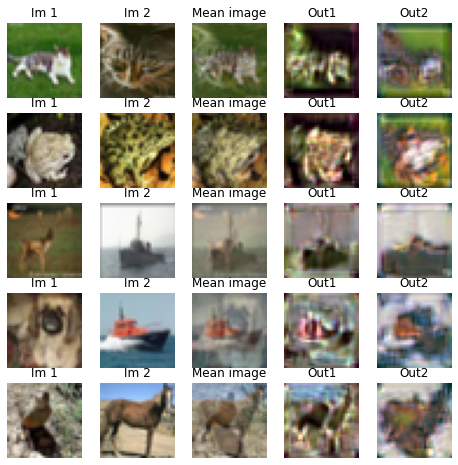

In [142]:
# Visualisation on 5 samples from the test dataset: 
visualize_results(generator, test_loader, num_samples = 5)

# Further explorations: 

- We can see that our models manage to learn the right colors albeit with a poor structure. Therefore, it would be interesting to add another term in the loss function (<a href="https://github.com/Po-Hsun-Su/pytorch-ssim">pytorch ssim loss</a>), encouraging the production of images with sharp and realistic structures. 

- It is difficult to compare the performance of different models as we do not have an objective function directly correlated with the quality of the outputs. One intuitive metric of performance is obtained by having human annotators to judge the visual quality of samples (Turing test). Therefore, as mentioned  in <a href="https://arxiv.org/pdf/1606.03498.pdf">"Improved techniques for training GANs"</a>, we could apply the inception score here. 
